<b>Dynamic simulation config:</b>

ASSIGN X freq 10<br/>
ASSIGN Y freq 10<br/>
PASS 48h<br/>
INC Y freq 10<br/>
INC Y scale 5<br/>
PASS 24h<br/>
INC Y scale 15<br/>
INC Y freq 10<br/>
PASS 24h<br/>
NORMALIZE Y scale <br/>
NORMALIZE Y freq<br/>
DEC Y freq 3<br/>
DEC Y scale 20<br/>
INC X freq 10<br/>
INC X scale 40<br/>
PASS 72h<br/>

<b>Notes: </b>

parameters:<br/>
freq - frequency<br/>
scale - scale for Weibull distribution<br/>

actions:<br/>
ASSIGN - set initial parameter<br/>
PASS value - perform simulations for during time<br/>
INC - increase param value<br/>
DEC - decrease param value<br/>
NORMALIZE - return parameters to <br/>

notes:<br/>
INC/DEC for frequency in specified in swaps per hour<br/>
INC/DEC for scale is specified in percentages relative to current value<br/>

In [405]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import json

In [365]:
pd.set_option('max_columns', 101)
sns.set_theme()


In [366]:
EXPERIMENT_ID = 63

In [367]:
BASE_DIR = fr'..\..\..\data\dynamic_simulations\experiment_{EXPERIMENT_ID}'
BASE_DIR

'..\\..\\..\\data\\dynamic_simulations\\experiment_63'

In [368]:
os.listdir(BASE_DIR)

['0', '1', '10', '11', '2', '3', '4', '5', '6', '7', '8', '9', 'config.json']

In [369]:
X_NAME = 'X'
Y_NAME = 'Y'

TOKEN_0 = X_NAME
TOKEN_1 = Y_NAME
INITIAL_RESERVE = 75000

In [370]:
class Simulation:
    def __init__(self,):
        self.occ_min = None
        self.initial_reserve_usd = None
        self.ratio_sec_usd = None
        self.amount_in_std = None
        self.amount_in_Y_std = None
      #  self.blo
    

In [371]:
def find_longest_blocked_sequence(s: pd.Series):
    cnt = 0
    max_cnt = 0
    
    for index, value in s.items():
        if value != 'SUCCESS':
            cnt += 1
        else:
            max_cnt = max(max_cnt, cnt)
            cnt = 0
    
    return max(max_cnt, cnt)

In [372]:
def remove_first_day(s: pd.Series):
    min_time = s.transaction_timestamp.min()
    seconds_day = (60*60*24)
    
    s = s[s.transaction_timestamp - min_time >= seconds_day]
    
    return s

In [373]:
def show_title(ax, stats_s, is_first, is_x_date=False, show_legend=True):
    initial_reserves_usd = row['initial_reserves_usd']
    blocks, blocks_vm, blocks_slippage, count = row['blocked_transactions'], row['blocked_by_volatility_mitigator'], row['blocked_exceeded_slippage'], row['count']

    ax.set_title(f'swaps: {count}\nblocks by vm / slippage: {blocks_vm/count*100:.1f}%/{blocks_slippage/count*100:.1f}%') #todo: iloc may differ from simulatuions df
    
    if is_x_date:
        fig.autofmt_xdate()

    if is_first and show_legend:
        fig.legend()

In [374]:
def read_simulation_stats(folder):
    simulation = {}
    
    config_filename = os.path.join(folder, 'config.json')
    swaps_filename = os.path.join(folder, 'swaps_normalized.csv')
    pool_state_filename = os.path.join(folder, 'pool_after_transaction_normalized.csv')
    
    with open(config_filename) as f:
        simulation = json.loads(f.read())
            
    pool_state_df = pd.read_csv(pool_state_filename)
    swaps_df = pd.read_csv(swaps_filename)
    
 #   simulation['id'] = simulation_id

    #print(swaps_filename)
    #print(swaps_df.shape)
    #print(swaps_df.status.value_counts())
    swaps_df = swaps_df[swaps_df.status != 'PENDING']
        
    simulation['count'] = swaps_df.shape[0]
    simulation['blocked_transactions'] = (swaps_df.status != 'SUCCESS').sum()
    simulation['blocked_transactions_pct'] = simulation['blocked_transactions']/len(swaps_df)

    simulation['blocked_by_volatility_mitigator'] = (swaps_df.status == 'BLOCKED_BY_VOLATILITY_MITIGATION').sum()
    simulation['blocked_by_volatility_mitigator_pct'] = simulation['blocked_by_volatility_mitigator'] / simulation['blocked_transactions'] if simulation['blocked_transactions'] else None

    simulation['blocked_exceeded_slippage'] = (swaps_df.status == 'EXCEEDED_MAX_SLIPPAGE').sum()
    simulation['blocked_exceeded_slippage_pct'] = simulation['blocked_exceeded_slippage'] / simulation['blocked_transactions'] if simulation['blocked_transactions'] else None
    
    simulation['blocked_not_enough_reserves'] = (swaps_df.status == 'NOT_ENOUGH_RESERVES').sum()
    simulation['blocked_not_enough_reserves_pct'] = simulation['blocked_not_enough_reserves'] / simulation['blocked_transactions'] if simulation['blocked_transactions'] else None
    
    simulation['longest_blocked_sequence'] = find_longest_blocked_sequence(swaps_df.status)
    simulation['longest_blocked_sequence_pct'] = simulation['longest_blocked_sequence'] / len(swaps_df) if simulation['blocked_transactions'] else None
    
    simulation['blocked_k_error'] = (swaps_df.status == 'K_ERROR').sum()
    simulation['blocked_k_error_pct'] = simulation['blocked_k_error'] / simulation['blocked_transactions'] if simulation['blocked_transactions'] else None
    
    simulation['amount_in_Y_std_success'] = swaps_df.loc[(swaps_df.token_in == Y_NAME) & (swaps_df.status == 'SUCCESS'), 'token_in_amount'].std()
    simulation['max_X_in_success'] = swaps_df.loc[(swaps_df.token_in == X_NAME) & (swaps_df.status == 'SUCCESS')].token_in_amount.max()
    simulation['max_Y_in_success'] = swaps_df.loc[(swaps_df.token_in == Y_NAME) & (swaps_df.status == 'SUCCESS')].token_in_amount.max()

    simulation['max_X_out_success'] = swaps_df.loc[(swaps_df.token_in == Y_NAME) & (swaps_df.status == 'SUCCESS')].token_out_amount.max()
    simulation['max_Y_out_success'] = swaps_df.loc[(swaps_df.token_in == X_NAME) & (swaps_df.status == 'SUCCESS')].token_out_amount.max()
    
    
    simulation['mean_X_in_success'] = swaps_df.loc[(swaps_df.token_in == X_NAME) & (swaps_df.status == 'SUCCESS')].token_in_amount.mean()
    simulation['mean_Y_in_success'] = swaps_df.loc[(swaps_df.token_in == Y_NAME) & (swaps_df.status == 'SUCCESS')].token_in_amount.mean()
    
    simulation['mean_X_out_success'] = swaps_df.loc[(swaps_df.token_in == Y_NAME) & (swaps_df.status == 'SUCCESS')].token_out_amount.mean()
    simulation['mean_Y_out_success'] = swaps_df.loc[(swaps_df.token_in == X_NAME) & (swaps_df.status == 'SUCCESS')].token_out_amount.mean()
    
    
    simulation['price_X_std'] = (pool_state_df['reserve_Y'] / pool_state_df['reserve_X']).std()
    simulation['price_Y_std'] = (pool_state_df['reserve_X'] / pool_state_df['reserve_Y']).std()
    
    g = swaps_df.groupby(['token_in', 'status']).size()
    simulation['success_X_in_ratio'] = g.loc[(X_NAME, 'SUCCESS')] /  g.loc[(Y_NAME, 'SUCCESS')]
    
    simulation['shape'] = float(simulation['shape'])
    simulation['scale'] = float(simulation['scale'])
    simulation['initial_reserves_usd'] = float(simulation['initial_reserves_usd'])
    
    return simulation

In [375]:
def read_config(config_filename):
    config = {}
    
    with open(config_filename) as f:
        return json.loads(f.read())

In [376]:
def remove_initial_swaps(df, initial_time_seconds):
    min_time = df.transaction_timestamp.min() + initial_time_seconds
    
    return df[df.transaction_timestamp >= min_time]

In [377]:
import datetime

def _read_simulation(folder:str):
    pool_state_before_transactions_path = os.path.join(folder, 'pool_before_transaction_normalized.csv')
    pool_state_after_transactions_path = os.path.join(folder, 'pool_after_transaction_normalized.csv')
    swap_transactions_path = os.path.join(folder, 'swaps_normalized.csv')
    config_path = os.path.join(folder, 'config.json')
        
    # read swaps
    pool0_df = pd.read_csv(pool_state_before_transactions_path)
    pool1_df = pd.read_csv(pool_state_after_transactions_path)
    swaps_df = pd.read_csv(swap_transactions_path)
    config = read_config(config_path)
    stats = read_simulation_stats(folder)
    
    pool0_df.columns = pool0_df.columns.map(lambda x : x + '_before' if x != 'transaction_id' else x)
    
    swaps_df = remove_initial_swaps(swaps_df, 24*60*60)

    swaps_df = pd.merge(swaps_df, pool0_df, left_on='id', right_on='transaction_id')
    swaps_df = pd.merge(swaps_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    swaps_df['transaction_timestamp'] = pd.to_datetime(swaps_df.transaction_timestamp, unit='s')
    swaps_df['block_timestamp'] = pd.to_datetime(swaps_df.block_timestamp, unit='s')
    
    swaps_df.loc[:, 'X_price'] = swaps_df['reserve_Y'] / swaps_df['reserve_X']
    
    # price impact of swap / 100%
    swaps_df.loc[:, 'price_diff'] = (swaps_df['reserve_Y'] / swaps_df['reserve_X'] - swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before']) / (swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before'])
    
    #print('RS', swap_transactions_path)
    #print('RS', swaps_df.shape)
    
    return swaps_df, config, stats

In [378]:
def read_simulation_iter(folder, iteration_id):
    '''
    At each iteration 2 simulation are being performed: with volatility mitigation mechanism disabled and enabled
    '''
    sim0 = _read_simulation(os.path.join(folder, '0'), )
    sim1 = _read_simulation(os.path.join(folder, '1'))
    
    return sim0, sim1

In [379]:
simulations = []
config_list = []
stats_list = []

cnt = 0
for i, simulation_id in enumerate(os.listdir(BASE_DIR)):
    if simulation_id.endswith('.json') or simulation_id.endswith('.csv'): # todo: continue if any file
        continue
        
    sim_path = os.path.join(BASE_DIR, simulation_id)
    
    sim0, sim1 = read_simulation_iter(sim_path, simulation_id)
    sim0[2]['sim_index'] = 2*i
    sim1[2]['sim_index'] = 2*i + 1
    
    simulations.extend([sim0[0], sim1[0]])
    config_list.extend([sim0[1], sim1[1]])
    stats_list.extend([sim0[2], sim1[2]])

In [380]:
config_df = pd.DataFrame.from_records(config_list)
stats_df = pd.DataFrame.from_records(stats_list)

In [381]:
filtered_stats_df = stats_df[(stats_df['volatility_mitigator'] == True) ].copy()
filtered_stats_df

,window_size,granularity,price_tollerance_threshold,initial_reserves_usd,volatility_mitigator,shape,scale,count,blocked_transactions,blocked_transactions_pct,blocked_by_volatility_mitigator,blocked_by_volatility_mitigator_pct,blocked_exceeded_slippage,blocked_exceeded_slippage_pct,blocked_not_enough_reserves,blocked_not_enough_reserves_pct,longest_blocked_sequence,longest_blocked_sequence_pct,blocked_k_error,blocked_k_error_pct,amount_in_Y_std_success,max_X_in_success,max_Y_in_success,max_X_out_success,max_Y_out_success,mean_X_in_success,mean_Y_in_success,mean_X_out_success,mean_Y_out_success,price_X_std,price_Y_std,success_X_in_ratio,sim_index
1,24,24,98,75000.0,True,0.712414,488.062173,4761,418,0.087797,418,1.0,0,0.0,0,0.0,7,0.001470,0,0.0,2529.911121,32172.112467,23751.525221,38406.674386,52781.824158,1744.222538,1592.861245,1486.985731,1710.442060,2.281338,3.220904,0.937974,1
3,24,24,98,75000.0,True,0.944742,161.127859,4742,0,0.000000,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,65.756732,733.209408,497.960834,720.268136,1015.765825,71.010506,55.827272,53.369729,65.787409,0.479540,0.564373,1.011880,3
5,24,24,98,75000.0,True,1.940407,4520.252052,4694,229,0.048786,229,1.0,0,0.0,0,0.0,7,0.001491,0,0.0,1288.867269,9403.376795,8553.550962,23845.161724,30648.735227,1958.238645,1709.016984,1794.018081,1809.745195,1.614741,1.593699,0.943840,5
7,24,24,98,75000.0,True,2.259941,4193.317737,4709,189,0.040136,189,1.0,0,0.0,0,0.0,7,0.001487,0,0.0,1130.618218,8628.747146,6386.765214,17233.628599,18086.865558,1853.495211,1537.429007,1795.857329,1546.538332,1.098978,1.394666,0.992945,7
9,24,24,98,75000.0,True,1.338950,161.127859,4786,0,0.000000,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,53.851947,585.037535,423.829081,487.676554,710.723837,66.674247,54.171321,49.322709,63.843105,0.578194,0.615765,1.016856,9
11,24,24,98,75000.0,True,0.957096,1941.103571,4780,138,0.028870,138,1.0,0,0.0,0,0.0,8,0.001674,0,0.0,979.709041,10371.642731,9119.041040,17287.974420,27904.543895,927.076170,824.406418,788.849256,936.731036,1.449319,1.164678,0.884693,11
13,24,24,98,75000.0,True,1.276630,1614.169257,4759,124,0.026056,124,1.0,0,0.0,0,0.0,7,0.001471,0,0.0,635.817614,5083.778279,5452.960052,11773.995751,14347.652251,746.101360,623.486585,675.172898,668.126768,1.327219,1.268260,0.941768,13
15,24,24,98,75000.0,True,1.596164,1287.234942,4802,128,0.026656,128,1.0,0,0.0,0,0.0,6,0.001249,0,0.0,440.435070,4390.240587,3102.103686,6032.695601,9365.232349,579.619748,484.207805,539.372194,501.675828,1.337857,1.225613,0.982188,15
17,24,24,98,75000.0,True,1.288985,3394.144969,4736,194,0.040963,194,1.0,0,0.0,0,0.0,9,0.001900,0,0.0,1219.133405,10076.651784,8845.117071,19964.283026,20616.172653,1463.689687,1285.178326,1251.838554,1437.315991,1.442054,1.147582,0.898036,17
19,24,24,98,75000.0,True,1.608519,3067.210654,4812,190,0.039485,190,1.0,0,0.0,0,0.0,7,0.001455,0,0.0,959.689185,7606.489727,5799.251618,18515.471278,20883.471858,1320.597841,1134.780460,1113.550536,1312.058486,1.829036,1.240896,0.863710,19


In [382]:
import math

def get_success_ratio_df(swaps1_df, x_upper_limit, bins=10):
    bandwidth = x_upper_limit // bins
    MAX = x_upper_limit
    #swaps1_df[swaps1_df.token_in == 'Y'].token_in_amount.max() # HARDCODED Y_NAME
    success_ratio_df = pd.DataFrame(columns=['lower', 'upper', 'ratio', 'occur'])

    for index, i in enumerate(range(0, math.ceil(MAX - bandwidth + 1), int(bandwidth))):
        a, b = i, i + bandwidth

        range_swaps_y_df = swaps1_df[(swaps1_df.token_in == 'Y') & (swaps1_df.token_in_amount >= a) &
                                      (swaps1_df.token_in_amount <= b)]

        success_cnt = range_swaps_y_df[range_swaps_y_df.status == 'SUCCESS'].shape[0]
        blocked_vm_cnt = range_swaps_y_df[range_swaps_y_df.status == 'BLOCKED_BY_VOLATILITY_MITIGATION'].shape[0]
        total_cnt = range_swaps_y_df.shape[0]
        
        if total_cnt != 0:#???
            success_ratio = success_cnt / total_cnt

            success_ratio_df.loc[index] = [a, b, success_ratio, total_cnt]
    
    return success_ratio_df

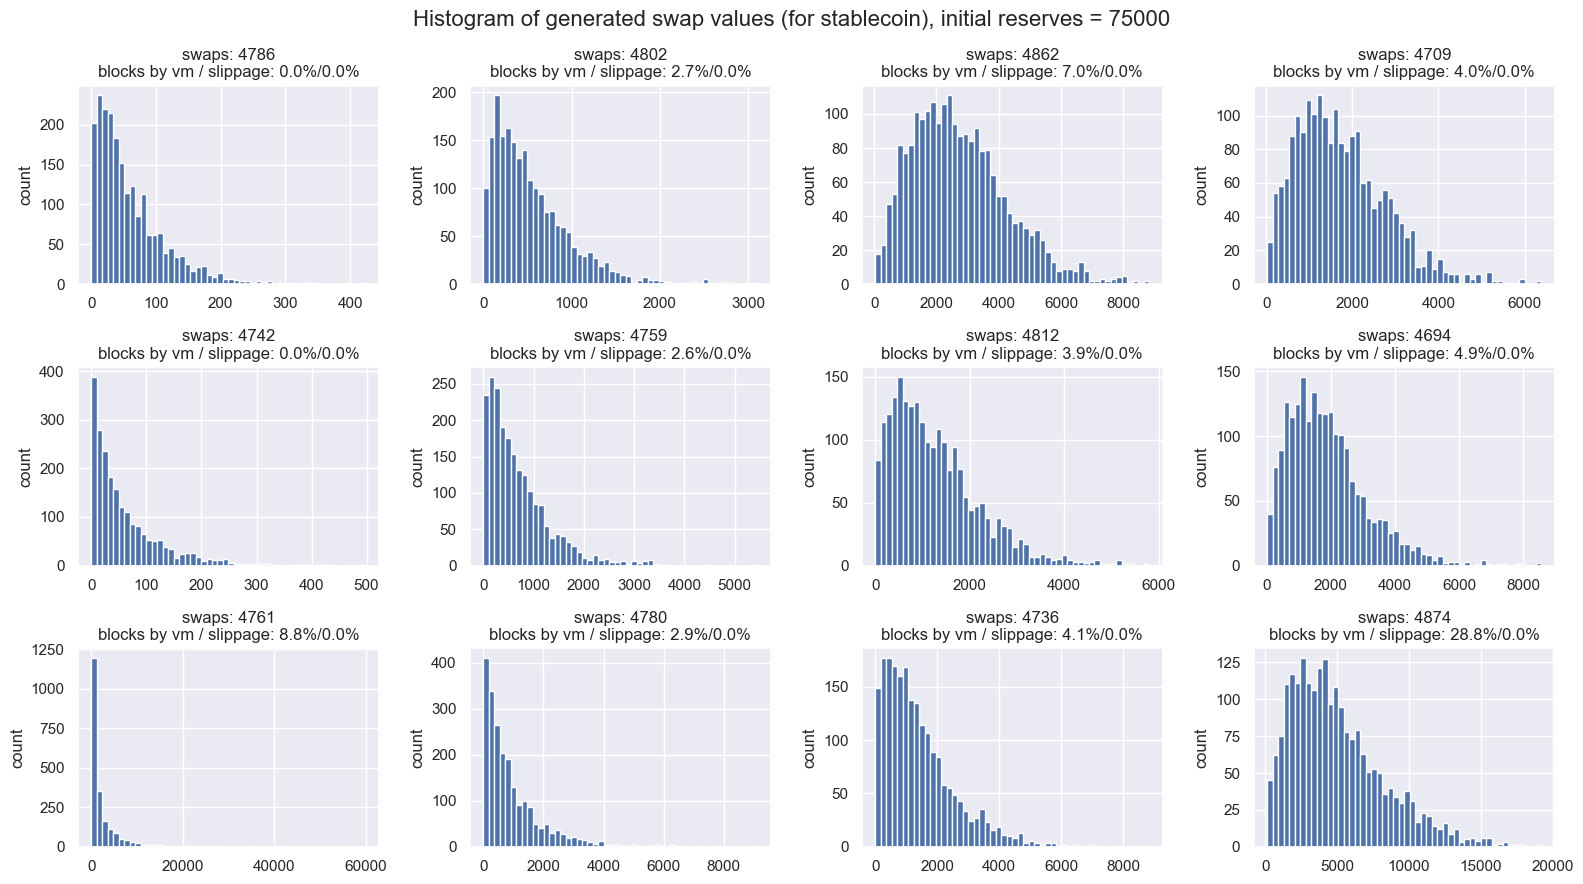

In [383]:

N = len(filtered_stats_df)
COLS = 4
ROWS = N//COLS + (N%COLS != 0)

filtered_stats_df.sort_values(by=['scale', 'shape'], inplace=True, ascending=[True, False])

fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS*4, ROWS*3))
axes = ax.ravel()
axes = axes.reshape(ROWS, COLS).T.ravel()

#filtered_stats_df.sort_values(by=['shape', 'scale'], inplace=True)

i = 0
for index, row in filtered_stats_df.iterrows():
    ax = axes[i]
    
    initial_reserves_usd, blocks, count =  row['initial_reserves_usd'], row['blocked_transactions'], row['count']
    
    df = simulations[row['sim_index']]
        
#    #print(success_ratio_df)
    values = df[df.token_in == 'Y'].token_in_amount.copy()
    ax.hist(values, bins=50)
    ax.set_ylabel('count')
    show_title(ax, row, i==0, show_legend=False)
    
    i += 1
    
fig.suptitle(f'Histogram of generated swap values (for stablecoin), initial reserves = {INITIAL_RESERVE}', fontsize=16)
fig.tight_layout()


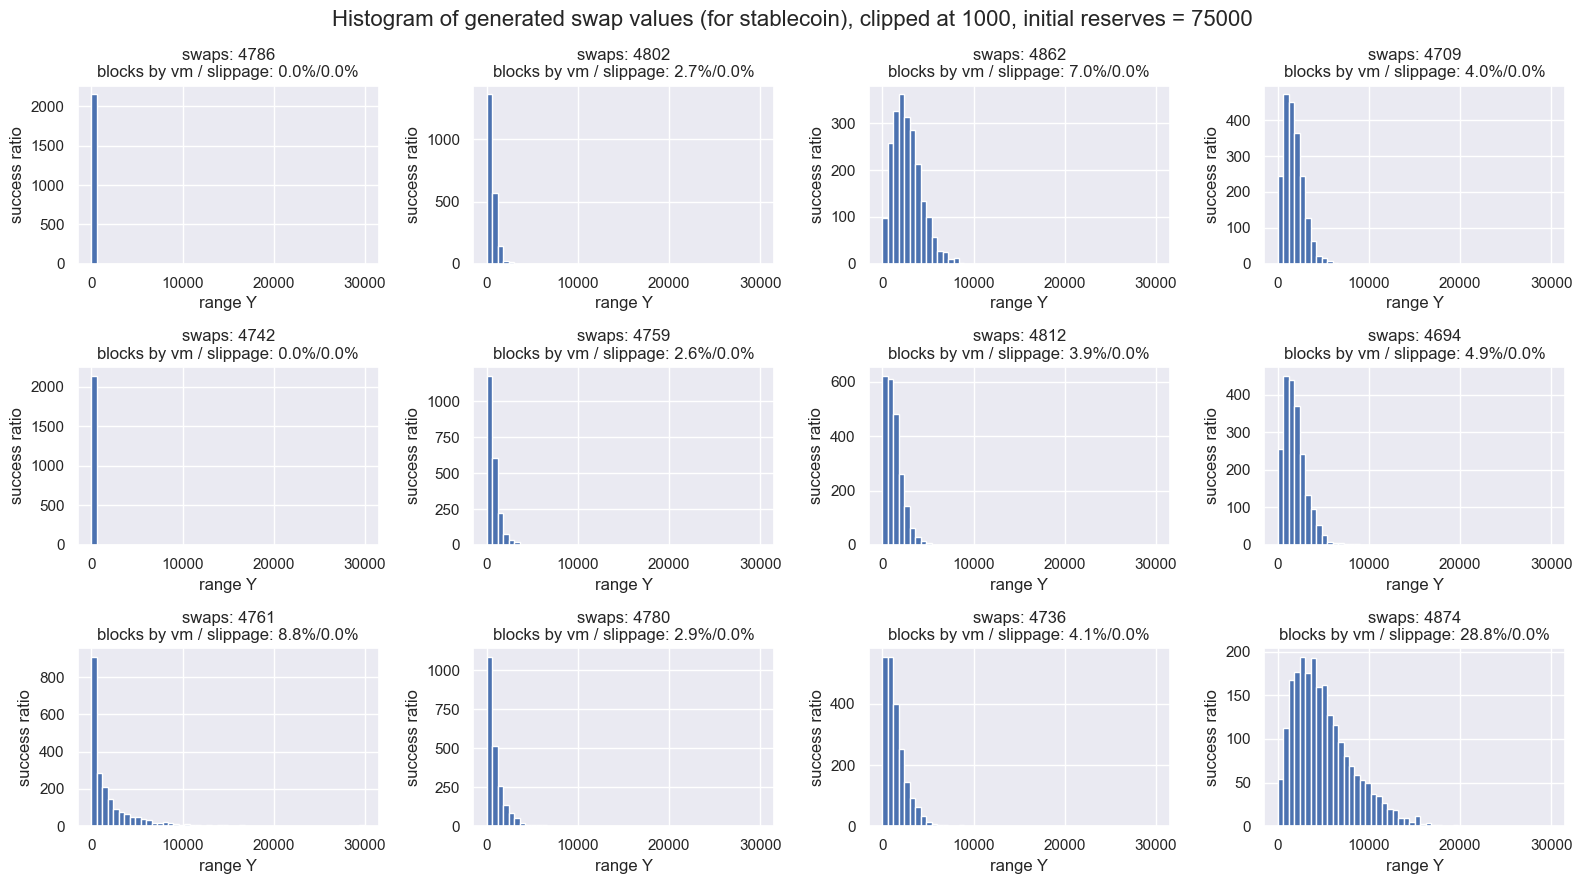

In [384]:

N = len(filtered_stats_df)
COLS = 4
ROWS = N//COLS + (N%COLS != 0)

filtered_stats_df.sort_values(by=['scale', 'shape'], inplace=True, ascending=[True, False])

fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS*4, ROWS*3))
axes = ax.ravel()
axes = axes.reshape(ROWS, COLS).T.ravel()

i = 0
for index, row in filtered_stats_df.iterrows():
    ax = axes[i]
    
    
    df = simulations[row['sim_index']]

    values = df[df.token_in == 'Y'].token_in_amount.copy()
    upper_limit = 30000
    values[values > upper_limit] = upper_limit
    ax.hist(values, bins=50, range=(0, upper_limit))
    
 #   ax2 = ax.twinx()
 #   ax2.set_ylim(0, 250)
    
    show_title(ax, row, i==0, show_legend=False)
    ax.set_xlabel('range Y')
    ax.set_ylabel('success ratio')

    
    i += 1
    
fig.suptitle(f'Histogram of generated swap values (for stablecoin), clipped at 1000, initial reserves = {INITIAL_RESERVE}', fontsize=16)
fig.tight_layout()


In [387]:
def plot_frequency(ax, swaps0_df, swaps_df, blocks, count, is_first, resample_interval='1h'):
    swaps_x_indexed_df = swaps_df[swaps_df.token_in == 'X'].copy().set_index('transaction_timestamp')
    swaps_y_indexed_df = swaps_df[swaps_df.token_in == 'Y'].copy().set_index('transaction_timestamp')
    
    swaps_x_indexed_df = swaps_x_indexed_df.resample(resample_interval).size()
    swaps_y_indexed_df = swaps_y_indexed_df.resample(resample_interval).size()

    ax.plot_date(x=swaps_x_indexed_df.index, y=swaps_x_indexed_df, linestyle='solid', marker=None, label='in X', )
    ax.plot_date(x=swaps_y_indexed_df.index, y=swaps_y_indexed_df, linestyle='solid', marker=None, label='in Y', color='orange')

  #  ax.set_title(f'Variation of Price X ({X_NAME}) over time')
    #ax.set_ylim(0, 3)
    ax.set_xlabel('Time')
    
    

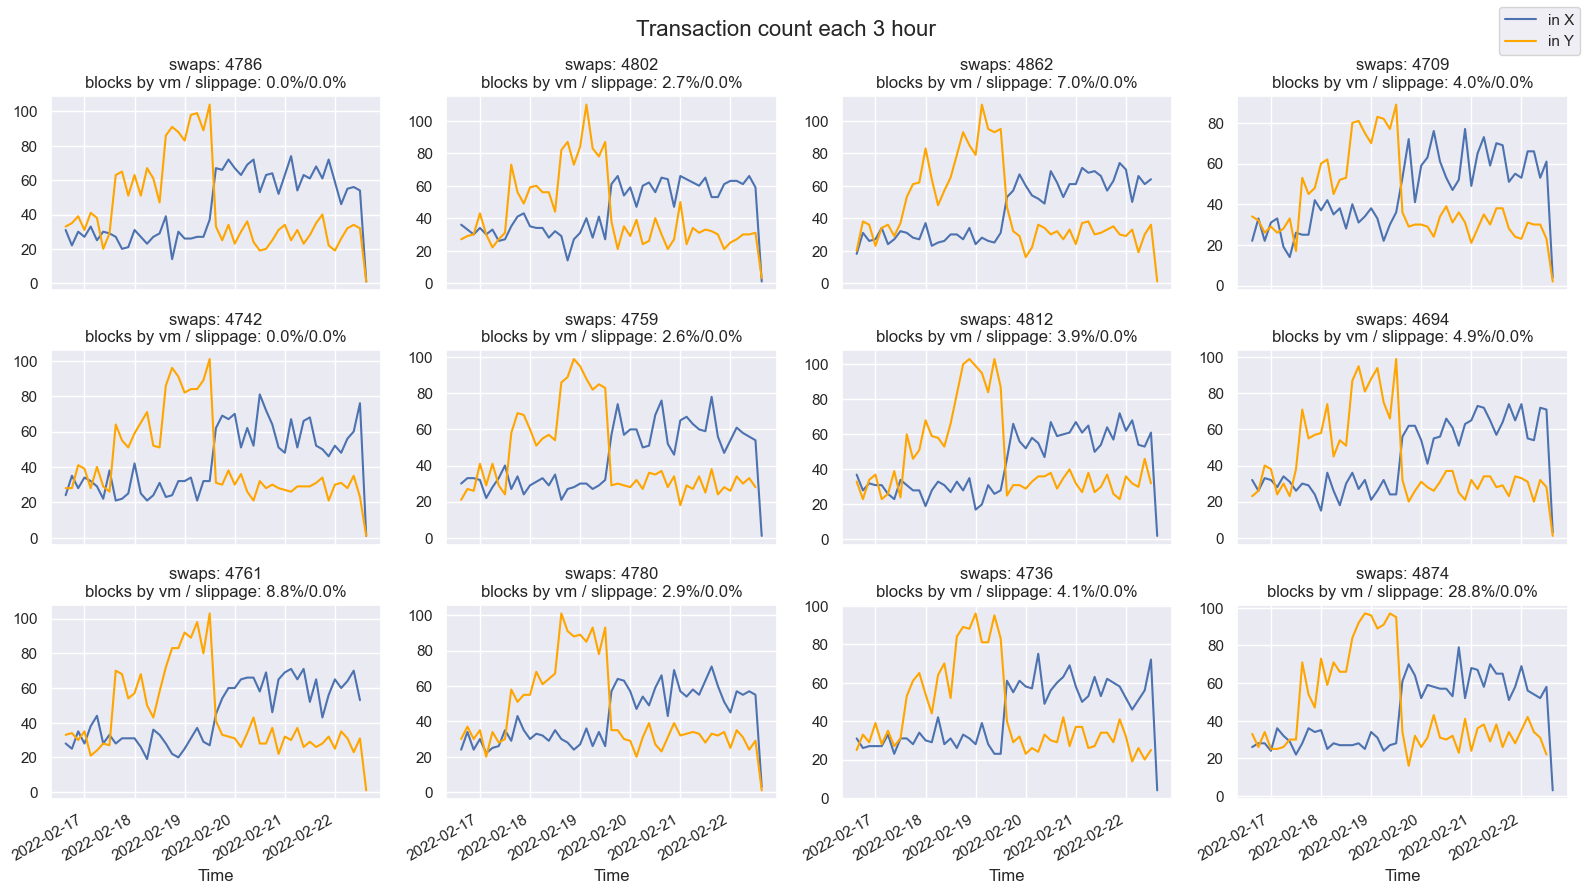

In [388]:
N = len(filtered_stats_df)
COLS = 4
ROWS = N//COLS + (N%COLS != 0)

filtered_stats_df.sort_values(by=['scale', 'shape'], inplace=True, ascending=[True, False])

fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS*4, ROWS*3))
axes = ax.ravel()
axes = axes.reshape(ROWS, COLS).T.ravel()

with warnings.catch_warnings():
    warnings.simplefilter('ignore')

   # filtered_stats_df.sort_values(by=['shape', 'scale'], inplace=True)

    i = 0
    for index, row in filtered_stats_df.iterrows():
        ax = axes[i]

      #  scale, shape, initial_reserves_usd, blocks, count = row['scale'], row['shape'], row['initial_reserve_usd'], row['blocked_transactions'], row['count']

        df0, df1 = simulations[row['sim_index'] - 1], simulations[row['sim_index']]
        plot_frequency(ax, df0, df1,  blocks, count, i == 0, '3h')
        show_title(ax, row, i==0, True, show_legend=True)

        i += 1

    fig.suptitle(f'Transaction count each 3 hour', fontsize=16)
    fig.tight_layout()


In [389]:
def plot_amount_in(ax, swaps0_df, swaps_df, blocks, count, is_first, resample_interval='1h'):
    swaps_x_indexed_df = swaps_df[swaps_df.token_in == 'X'].copy().set_index('transaction_timestamp')
    swaps_y_indexed_df = swaps_df[swaps_df.token_in == 'Y'].copy().set_index('transaction_timestamp')
    
    swaps_x_indexed_df = swaps_x_indexed_df.resample(resample_interval).token_in_amount.sum()
    swaps_y_indexed_df = swaps_y_indexed_df.resample(resample_interval).token_in_amount.sum()

    ax.plot_date(x=swaps_x_indexed_df.index, y=swaps_x_indexed_df, linestyle='solid', marker=None, label='in X', )
    ax.plot_date(x=swaps_y_indexed_df.index, y=swaps_y_indexed_df, linestyle='solid', marker=None, label='in Y', color='orange')

  #  ax.set_title(f'Variation of Price X ({X_NAME}) over time')
    #ax.set_ylim(0, 3)
    ax.set_xlabel('Time')
    
    

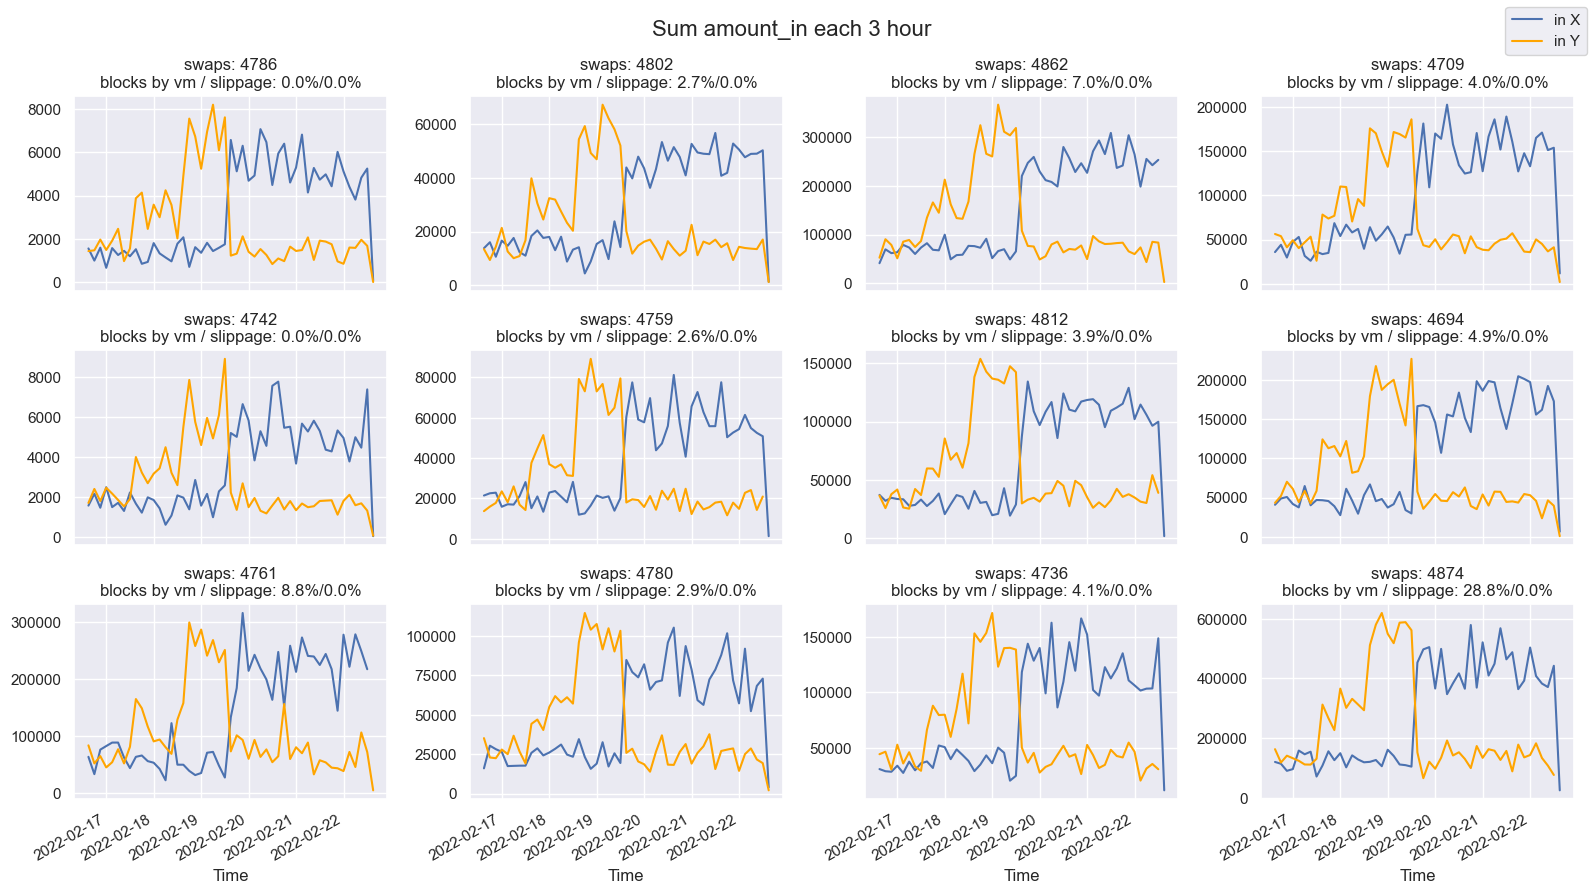

In [390]:
N = len(filtered_stats_df)
COLS = 4
ROWS = N//COLS + (N%COLS != 0)

filtered_stats_df.sort_values(by=['scale', 'shape'], inplace=True, ascending=[True, False])

fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS*4, ROWS*3))
axes = ax.ravel()
axes = axes.reshape(ROWS, COLS).T.ravel()

with warnings.catch_warnings():
    warnings.simplefilter('ignore')

   # filtered_stats_df.sort_values(by=['shape', 'scale'], inplace=True)

    i = 0
    for index, row in filtered_stats_df.iterrows():
        ax = axes[i]

      #  scale, shape, initial_reserves_usd, blocks, count = row['scale'], row['shape'], row['initial_reserve_usd'], row['blocked_transactions'], row['count']

        df0, df1 = simulations[row['sim_index'] - 1], simulations[row['sim_index']]
        plot_amount_in(ax, df0, df1,  blocks, count, i == 0, '3h')
        show_title(ax, row, i==0, True, show_legend=True)

        i += 1

    fig.suptitle(f'Sum amount_in each 3 hour', fontsize=16)
    fig.tight_layout()


In [391]:
def plot_blocked_datetime(ax, swaps0_df, swaps_df, scale, shape, blocks, count, is_first, resample_interval='1h'):
    success_df = swaps_df[swaps_df.status == 'SUCCESS']
    blocked_df = swaps_df[swaps_df.status != 'SUCCESS']
    
    blocked_df.index = blocked_df.transaction_timestamp
    success_df.index = success_df.transaction_timestamp
    
    success_s = success_df.resample(resample_interval).size()
    blocked_s = blocked_df.resample(resample_interval).size()
    
    ax.plot_date(x=success_s.index, y=success_s, linestyle='solid', marker=None, label='Success', color='green')
    ax.plot_date(x=blocked_s.index, y=blocked_s, linestyle='solid', marker=None, label='Blocked', color='red')

  #  ax.set_title(f'Variation of Price X ({X_NAME}) over time')
    #ax.set_ylim(0, 3)
    ax.set_xlabel('Time')
    ax.set_ylabel(Y_NAME)
    ax.set_title(f'scale = {scale}, shape = {shape}, blocks: {blocks} / {count}') #todo: iloc may differ from simulatuions df
    fig.autofmt_xdate()

    if is_first:
        fig.legend()

In [392]:
def plot_blocked_datetime(ax, swaps0_df, swaps_df, blocks, count, is_first, resample_interval='1h'):
    success_x_df = swaps_df[(swaps_df.status == 'SUCCESS') & ((swaps_df.token_in == 'X'))]
    success_y_df = swaps_df[(swaps_df.status == 'SUCCESS') & ((swaps_df.token_in == 'Y'))]
        
    blocked_x_df = swaps_df[(swaps_df.status != 'SUCCESS') & ((swaps_df.token_in == 'X'))]
    blocked_y_df = swaps_df[(swaps_df.status != 'SUCCESS') & ((swaps_df.token_in == 'Y'))]
    
    blocked_x_df.index = blocked_x_df.transaction_timestamp
    blocked_y_df.index = blocked_y_df.transaction_timestamp
    success_x_df.index = success_x_df.transaction_timestamp
    success_y_df.index = success_y_df.transaction_timestamp
    
    blocked_x_df.loc[success_y_df.index.max()] = None
    blocked_y_df.loc[success_y_df.index.max()] = None
    blocked_x_df.loc[success_y_df.index.min()] = None
    blocked_y_df.loc[success_y_df.index.min()] = None
    
    success_x_s = success_x_df.resample(resample_interval).size()
    success_y_s = success_y_df.resample(resample_interval).size()

    blocked_x_s = blocked_x_df.resample(resample_interval).size()
    blocked_y_s = blocked_y_df.resample(resample_interval).size()
    
    blocked_x_s.iloc[-1] -=1
    blocked_y_s.iloc[-1] -=1

    blocked_x_s.iloc[0] -=1
    blocked_y_s.iloc[0] -=1
    
    ratio_blocked_x = blocked_x_s / (success_x_s + blocked_x_s)
    ratio_blocked_y = blocked_y_s / (success_y_s + blocked_y_s)
    ratio_blocked_x[(success_x_s + blocked_x_s) == 0] = 0
    ratio_blocked_y[(success_y_s + blocked_y_s) == 0] = 0

    ax.plot_date(x=ratio_blocked_x.index, y=ratio_blocked_x, linestyle='solid', marker=None, label='in X', )
    ax.plot_date(x=ratio_blocked_y.index, y=ratio_blocked_y, linestyle='solid', marker=None, label='in Y', color='orange')

  #  ax.set_title(f'Variation of Price X ({X_NAME}) over time')
    #ax.set_ylim(0, 3)
    ax.set_xlabel('Time')    

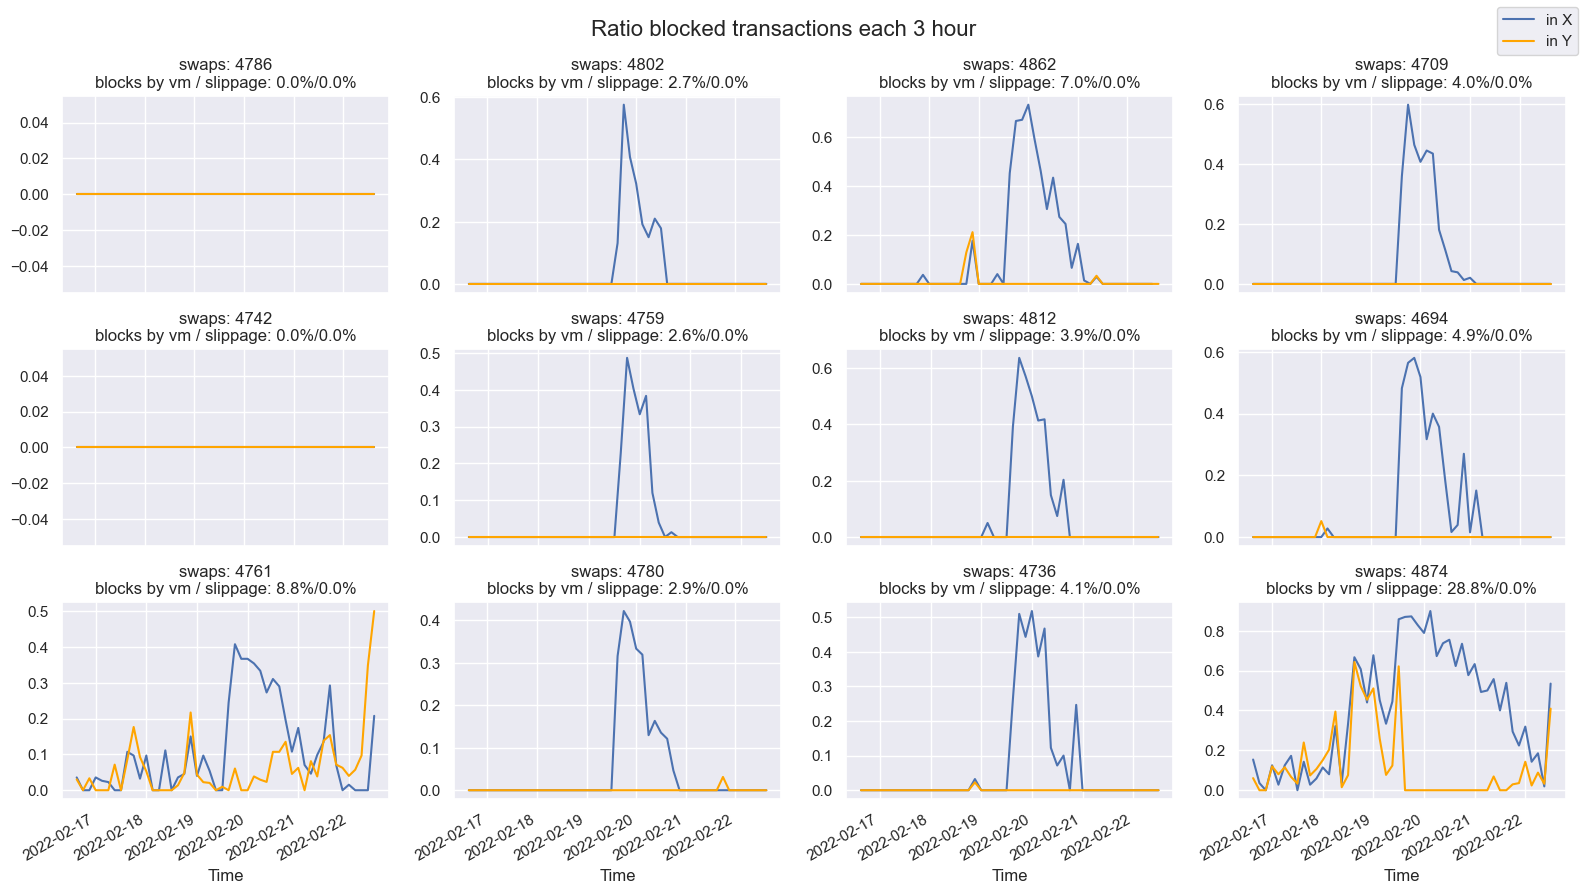

In [393]:
N = len(filtered_stats_df)
COLS = 4
ROWS = N//COLS + (N%COLS != 0)

filtered_stats_df.sort_values(by=['scale', 'shape'], inplace=True, ascending=[True, False])

fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS*4, ROWS*3))
axes = ax.ravel()
axes = axes.reshape(ROWS, COLS).T.ravel()

with warnings.catch_warnings():
    warnings.simplefilter('ignore')

   # filtered_stats_df.sort_values(by=['shape', 'scale'], inplace=True)

    i = 0
    for index, row in filtered_stats_df.iterrows():
        ax = axes[i]

      #  scale, shape, initial_reserves_usd, blocks, count = row['scale'], row['shape'], row['initial_reserve_usd'], row['blocked_transactions'], row['count']

        df0, df1 = simulations[row['sim_index'] - 1], simulations[row['sim_index']]
        plot_blocked_datetime(ax, df0, df1,  blocks, count, i == 0, '3h')
        show_title(ax, row, i==0, True, show_legend=True)

        i += 1

    fig.suptitle(f'Ratio blocked transactions each 3 hour', fontsize=16)
    fig.tight_layout()


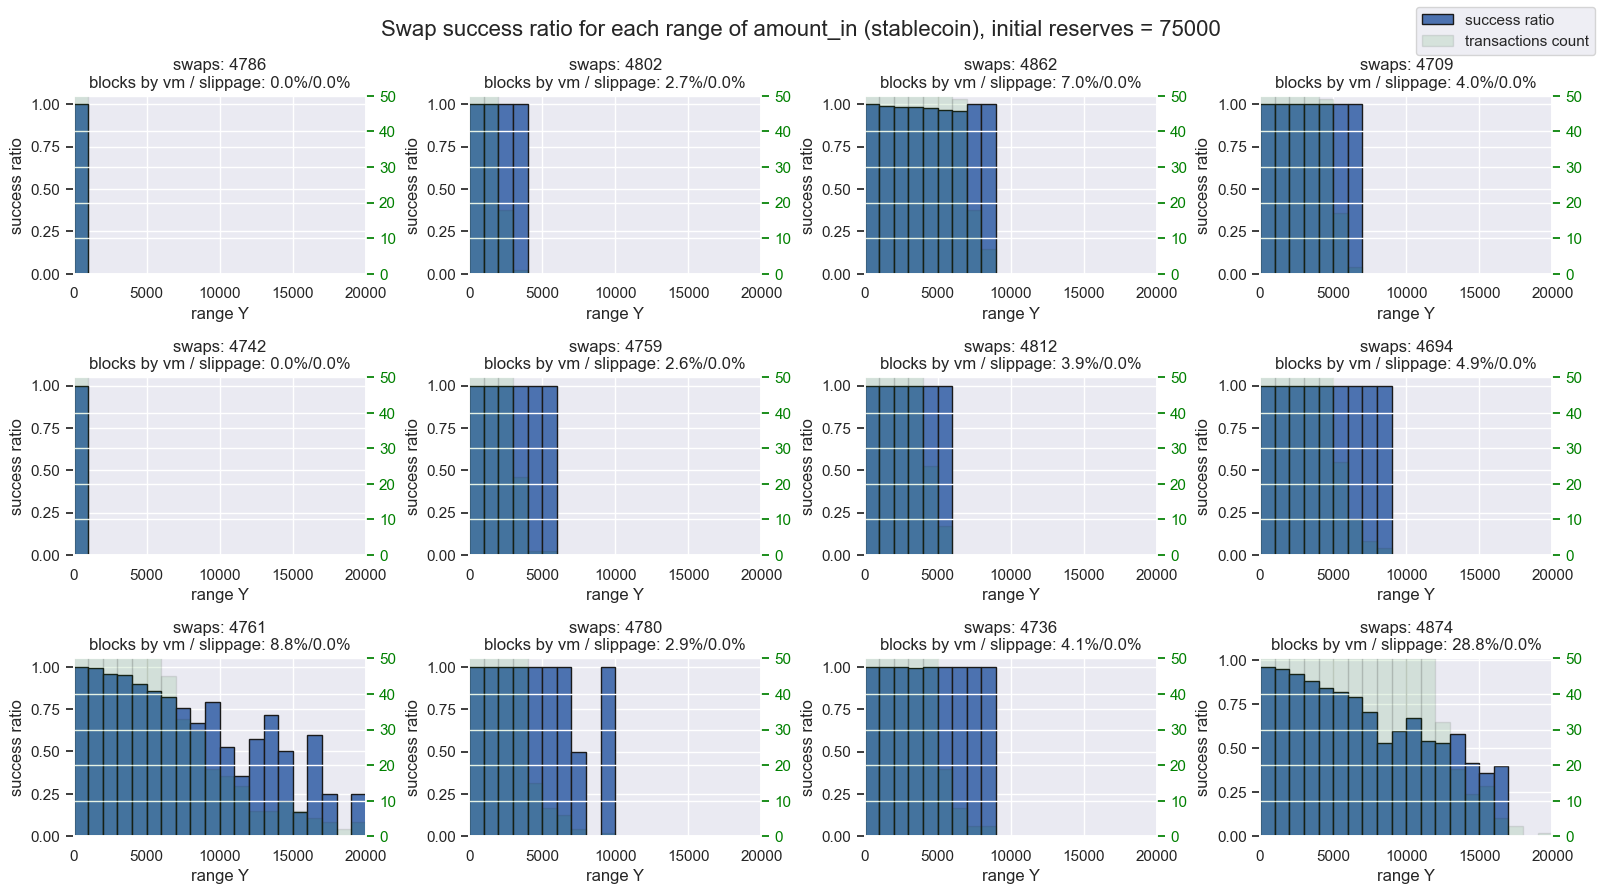

In [394]:

N = len(filtered_stats_df)
COLS = 4
ROWS = N//COLS + (N%COLS != 0)

filtered_stats_df.sort_values(by=['scale', 'shape'], inplace=True, ascending=[True, False])

fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS*4, ROWS*3))
axes = ax.ravel()
axes = axes.reshape(ROWS, COLS).T.ravel()

i = 0
for index, row in filtered_stats_df.iterrows():
    ax = axes[i]
    
    
    df = simulations[row['sim_index']]
    

    x_upper_limit = 20000
    success_ratio_df = get_success_ratio_df(df, x_upper_limit, 20)
    #print(success_ratio_df)
    
        
    ax2 = ax.twinx()
    ax2.bar(success_ratio_df.lower, success_ratio_df.occur, width=success_ratio_df.upper-success_ratio_df.lower, ec="k", align="edge", label='transactions count', color='green', alpha=0.1)
    ax2.set_ylim(0, 50)
    ax2.tick_params(axis='y', colors='green')
    #ax.tick_params(axis='y', colors='blue')

    ax.set_xlabel('range Y')
    ax.set_ylabel('success ratio')
    #ax.set_title(f'scale = {scale}, shape = {shape}, blocks: {blocks} / {count}') #todo: iloc may differ from simulatuions df
    
    ax.set_xlim(0, x_upper_limit)
    ax.bar(success_ratio_df.lower, success_ratio_df.ratio, width=success_ratio_df.upper-success_ratio_df.lower, ec="k", align="edge", label='success ratio')

    show_title(ax, row, i==0, show_legend=False)

    if i==0:
        fig.legend()
    i += 1
    
fig.suptitle(f'Swap success ratio for each range of amount_in (stablecoin), initial reserves = {INITIAL_RESERVE}', fontsize=16)
fig.tight_layout()


In [395]:
def slice_factor_curve(ax, swaps1_df):
    sns.scatterplot(data=swaps1_df[swaps1_df.mitigator_check_status == 'CHECKED'], x='slice_factor', y='out_amount_diff', hue='status', ax=ax)

    slice_factor = np.arange(0, 100)
    slice_factor_curve = slice_factor * np.sqrt(slice_factor).astype(int)
    slice_factor_curve[slice_factor_curve > 98] = 98
    out_amount_diff = (100 - slice_factor_curve)
    g = sns.lineplot(x=slice_factor, y=out_amount_diff, color='red', label='out_amount_diff_limit', ax=ax)
    g.legend_.remove()

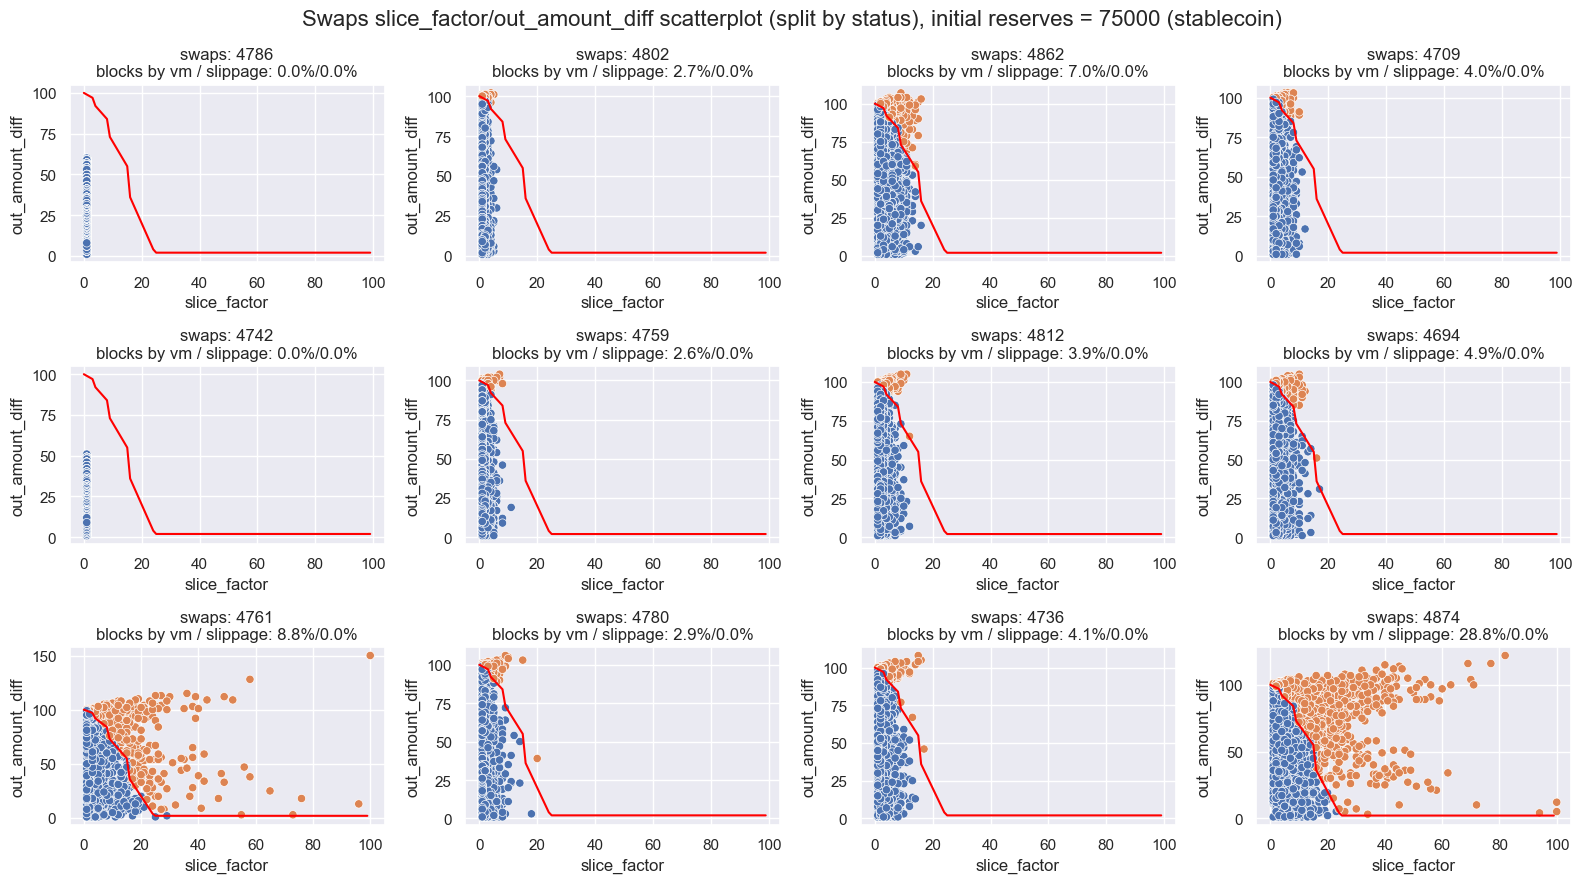

In [396]:
N = len(filtered_stats_df)
COLS = 4
ROWS = N//COLS + (N%COLS != 0)

filtered_stats_df.sort_values(by=['scale', 'shape'], inplace=True, ascending=[True, False])

fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS*4, ROWS*3))
axes = ax.ravel()
axes = axes.reshape(ROWS, COLS).T.ravel()
#filtered_stats_df.sort_values(by=['shape', 'scale'], inplace=True)

i = 0
for index, row in filtered_stats_df.iterrows():
    ax = axes[i]
    
    #scale, shape, initial_reserves_usd, blocks, count = row['scale'], row['shape'], row['initial_reserve_usd'], row['blocked_transactions'], row['count']
    
    df = simulations[row['sim_index']]
    slice_factor_curve(ax, df)
    show_title(ax, row, i==0, show_legend=False)

    i += 1
    
fig.suptitle(f'Swaps slice_factor/out_amount_diff scatterplot (split by status), initial reserves = {INITIAL_RESERVE} (stablecoin)', fontsize=16)
fig.tight_layout()


In [397]:
def plot_price_variation(ax, swaps0_df, swaps1_df, twap=False):
    ax.plot_date(x=swaps0_df['transaction_timestamp'], y=swaps0_df['X_price'], linestyle='solid', marker=None, label='Mitigator off', color='red')
    ax.plot_date(x=swaps1_df['transaction_timestamp'], y=swaps1_df['X_price'], linestyle='solid', marker=None, label='Mitigator on',)

    if twap:
        ax.plot_date(swaps1_df[swaps1_df.token_in =='X'].transaction_timestamp, swaps1_df[swaps1_df.token_in == 'X'].oracle_price, linestyle='solid', marker=None, color='orange', label='TWAP (mitigator on)')
        ax.plot_date(swaps1_df[swaps1_df.token_in =='Y'].transaction_timestamp, 1/swaps1_df[swaps1_df.token_in == 'Y'].oracle_price, linestyle='solid', marker=None, color='green')

    ax.set_xlabel('Swap timestamp')
    ax.set_ylabel(Y_NAME)


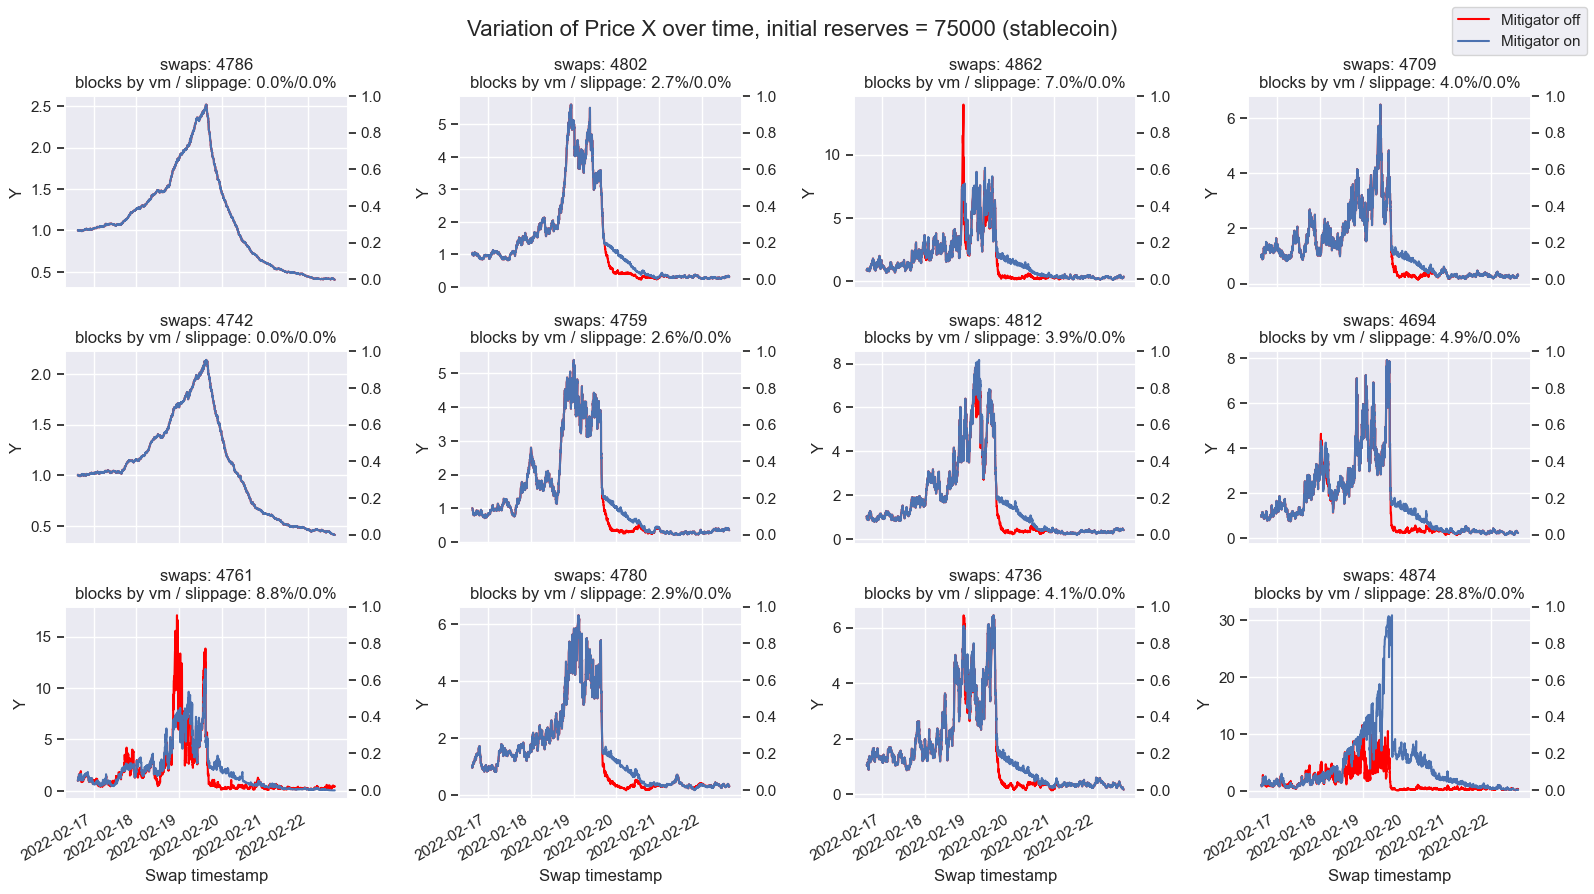

In [404]:
N = len(filtered_stats_df)
COLS = 4
ROWS = N//COLS + (N%COLS != 0)

filtered_stats_df.sort_values(by=['scale', 'shape'], inplace=True, ascending=[True, False])

fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS*4, ROWS*3))
axes = ax.ravel()
axes = axes.reshape(ROWS, COLS).T.ravel()

#filtered_stats_df.sort_values(by=['shape', 'scale'], inplace=True)

i = 0

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    for index, row in filtered_stats_df.iterrows():
        ax = axes[i]        
        df0, df1 = simulations[row['sim_index'] - 1], simulations[row['sim_index']]
        plot_price_variation(ax, df0, df1)
        show_title(ax, row, i==0, True, show_legend=True)
        
        ax2 = ax.twinx()
      #  plot_blocked_datetime(ax2, df0, df1,  blocks, count, i == 0, '1h')
        ax2.grid(False)
        ax2.set_ylim(-0.05, 1)
        i += 1

    fig.suptitle(f'Variation of Price {X_NAME} over time, initial reserves = {INITIAL_RESERVE} (stablecoin)', fontsize=16)
    fig.tight_layout()


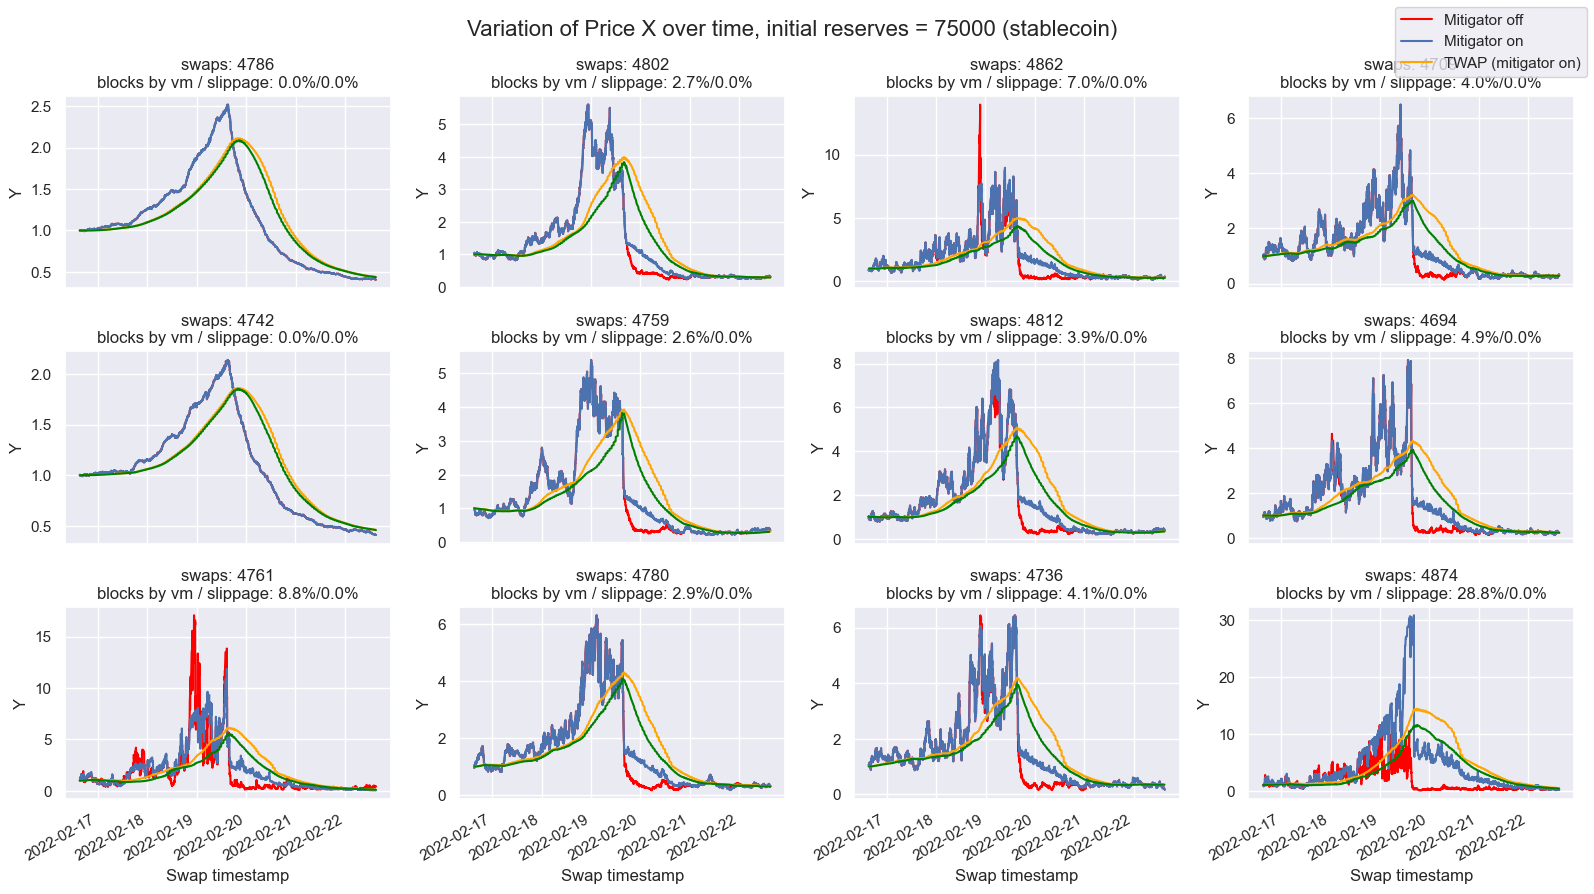

In [399]:
N = len(filtered_stats_df)
COLS = 4
ROWS = N//COLS + (N%COLS != 0)

filtered_stats_df.sort_values(by=['scale', 'shape'], inplace=True, ascending=[True, False])

fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS*4, ROWS*3))
axes = ax.ravel()
axes = axes.reshape(ROWS, COLS).T.ravel()

i = 0

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    for index, row in filtered_stats_df.iterrows():
        ax = axes[i]        
        df0, df1 = simulations[row['sim_index'] - 1], simulations[row['sim_index']]
        plot_price_variation(ax, df0, df1, twap=True)



        show_title(ax, row, i==0, True, show_legend=True)

        i += 1

    fig.suptitle(f'Variation of Price {X_NAME} over time, initial reserves = {INITIAL_RESERVE} (stablecoin)', fontsize=16)
    fig.tight_layout()


In [400]:
def plot_price_impact(ax, swaps0_df, swaps1_df):
    ax.plot_date(data=swaps0_df, x='transaction_timestamp', y='price_diff', linestyle='solid', color='red', marker=None, label='Volatility mitigator off')
    ax.plot_date(data=swaps1_df, x='transaction_timestamp', y='price_diff', linestyle='solid', marker=None, label='Volatility mitigator on')

  #  ax.set_title(f'Variation of Price X ({X_NAME}) over time')
    ax.set_ylim(-0.5, 0.5)
    ax.set_xlabel('Swap timestamp')
    ax.set_ylabel(Y_NAME)

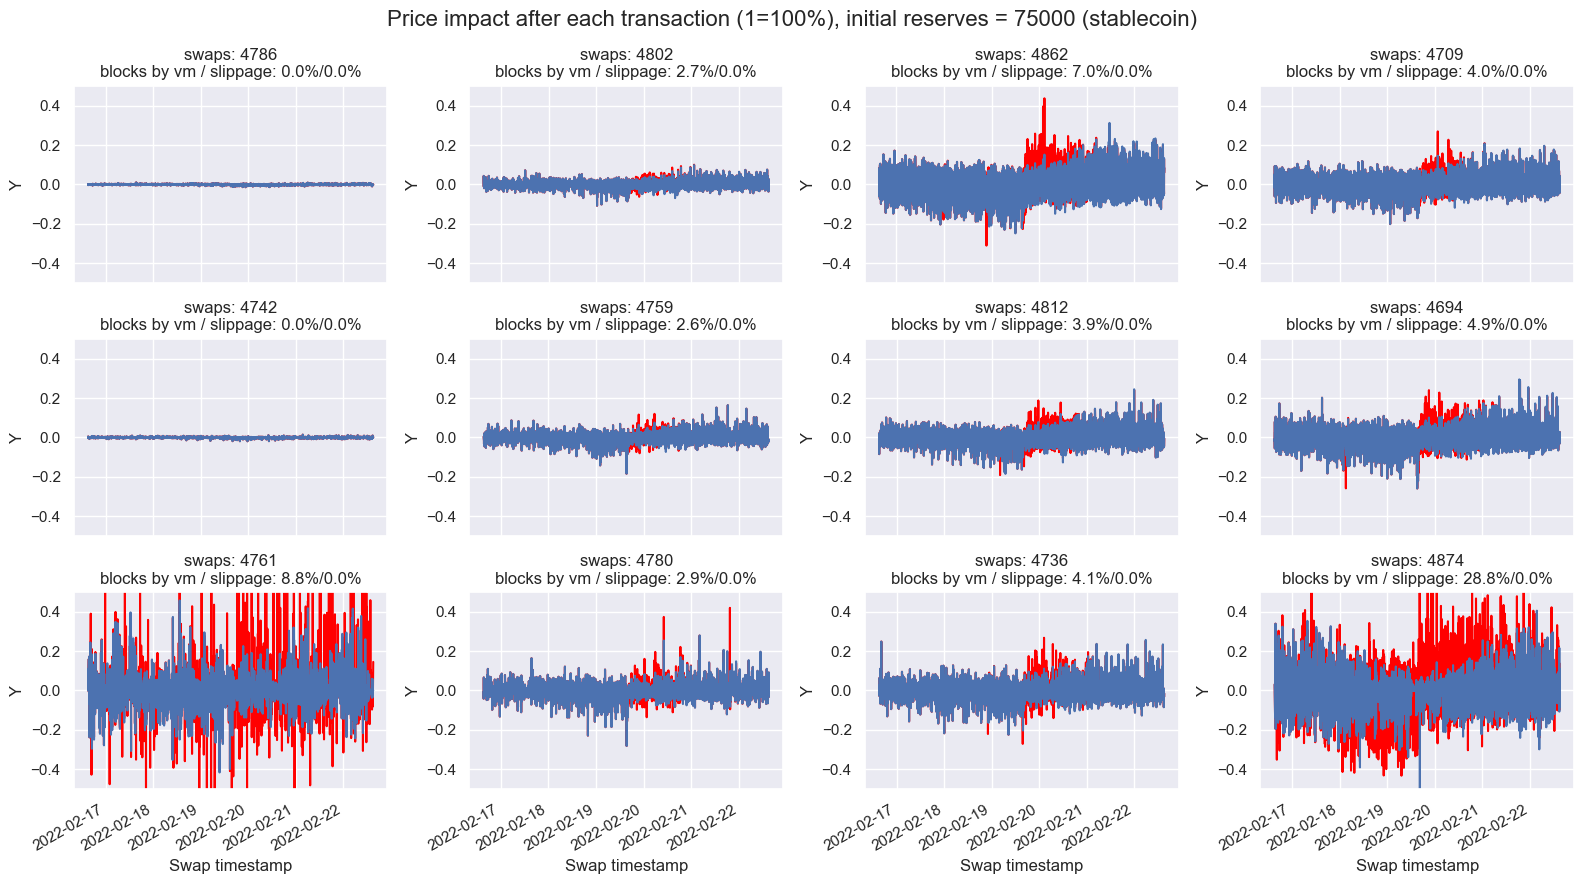

In [401]:
N = len(filtered_stats_df)
COLS = 4
ROWS = N//COLS + (N%COLS != 0)

filtered_stats_df.sort_values(by=['scale', 'shape'], inplace=True, ascending=[True, False])

fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS*4, ROWS*3))
axes = ax.ravel()
axes = axes.reshape(ROWS, COLS).T.ravel()

i = 0

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for index, row in filtered_stats_df.iterrows():
        ax = axes[i]

        df0, df1 = simulations[row['sim_index'] - 1], simulations[row['sim_index']]
        plot_price_impact(ax, df0, df1)
        show_title(ax, row, i==0, True, show_legend=False)

        i += 1

    fig.suptitle(f'Price impact after each transaction (1=100%), initial reserves = {INITIAL_RESERVE} (stablecoin)', fontsize=16)
    fig.tight_layout()


In [402]:
def plot_reserves(ax, swaps0_df, swaps1_df):
    ax.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_X, label='reserve X')

    ax.plot(swaps0_df.transaction_timestamp, swaps0_df.reserve_Y, color='red', label='reserve Y (stablecoin) mitigator off')
    ax.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_Y, color='orange', label='reserve Y (stablecoin) mitigator enabled')

   # ax.set_title(f'Variation of Price X ({X_NAME}) over time')
  #  ax.set_ylim(60000, 100000)
   # ax.set_xlabel('Swap timestamp')
  #  ax.set_ylabel(Y_NAME)
    #ax.set_title(f'scale = {scale}, shape = {shape}, blocks: {blocks} / {count}') #todo: iloc may differ from simulatuions df
    #fig.autofmt_xdate()

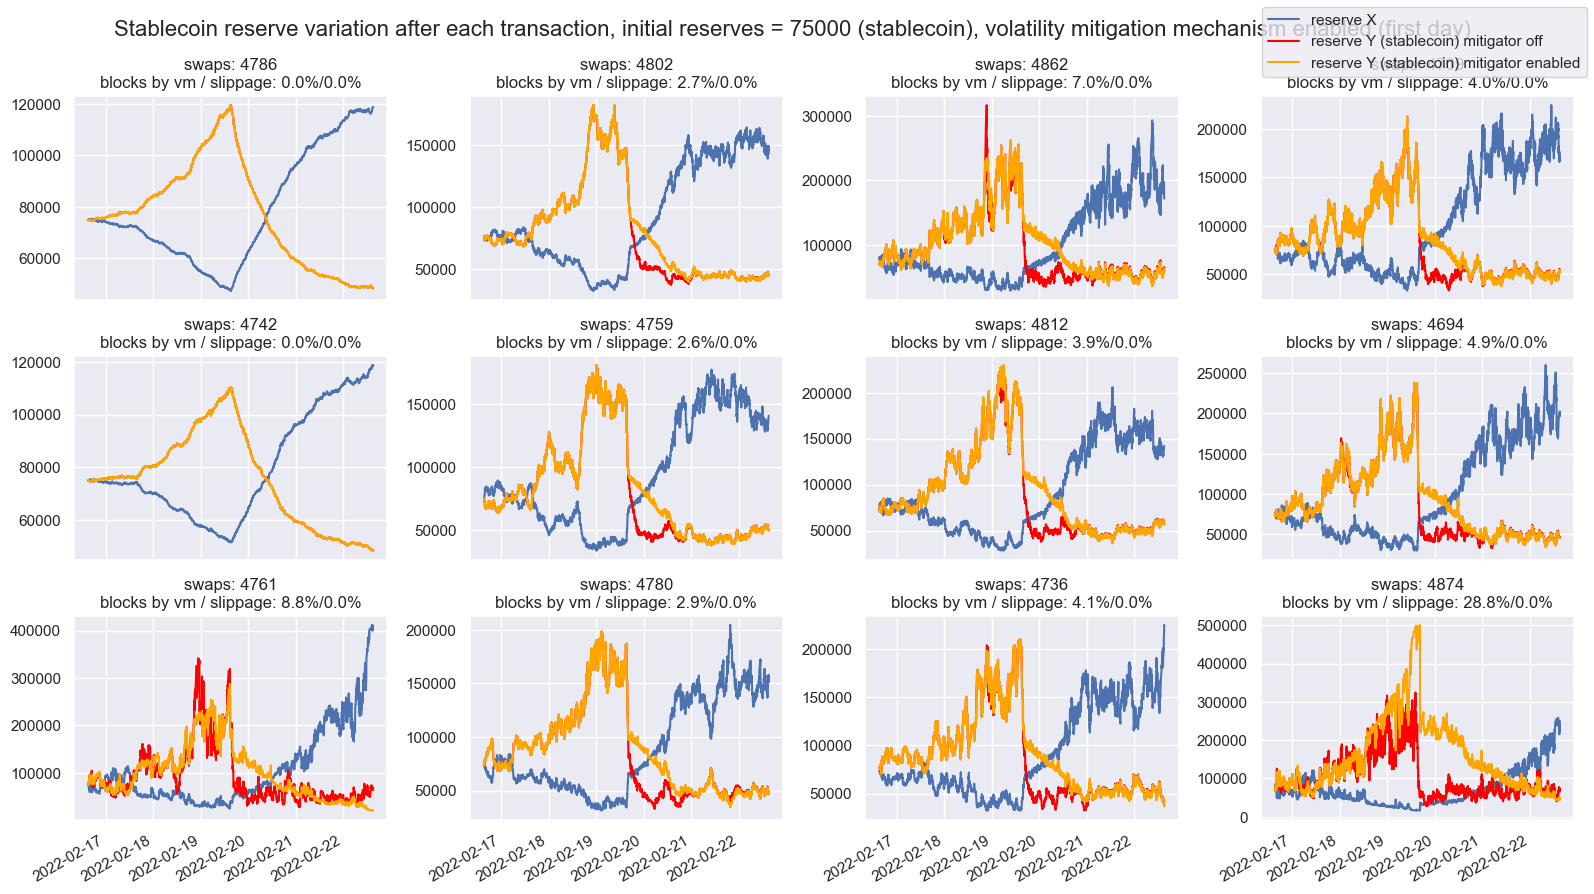

In [403]:
N = len(filtered_stats_df)
COLS = 4
ROWS = N//COLS + (N%COLS != 0)

filtered_stats_df.sort_values(by=['scale', 'shape'], inplace=True, ascending=[True, False])

fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS*4, ROWS*3))
axes = ax.ravel()
axes = axes.reshape(ROWS, COLS).T.ravel()

#filtered_stats_df.sort_values(by=['shape', 'scale'], inplace=True)

i = 0
for index, row in filtered_stats_df.iterrows():
    ax = axes[i]
        
    df0, df1 = simulations[row['sim_index'] - 1], simulations[row['sim_index']]
    plot_reserves(ax, df0, df1)
   # ax.set_xlim(simulations[row['sim_index'] - 1].transaction_timestamp.min(), simulations[row['sim_index'] - 1].transaction_timestamp.min() + datetime.timedelta(hours=24))
    show_title(ax, row, i==0, True, show_legend=True)
    
    i += 1
    
fig.suptitle(f'Stablecoin reserve variation after each transaction, initial reserves = {INITIAL_RESERVE} (stablecoin), volatility mitigation mechanism enabled (first day)', fontsize=16)
fig.tight_layout()


In [324]:
# pd.set_option('max_rows', 100)
# simulations[23].tail(100)